<a href="https://colab.research.google.com/github/karthikmax/Credit-Card-Churn/blob/main/CreditCardChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier)
from xgboost import XGBClassifier

Load Data

In [ ]:
data = pd.read_csv('/content/sample_data/BankChurners.csv')

In [ ]:
data.head()

CLIENTNUM     Attrition_Flag  ...  Avg_Utilization_Ratio Unnamed: 21
0  768805383  Existing Customer  ...                  0.061         NaN
1  818770008  Existing Customer  ...                  0.105         NaN
2  713982108  Existing Customer  ...                  0.000         NaN
3  769911858  Existing Customer  ...                  0.760         NaN
4  709106358  Existing Customer  ...                  0.000         NaN

[5 rows x 22 columns]

In [ ]:
data.shape

(10127, 22)

In [ ]:
data.isnull().sum()

CLIENTNUM                       0
Attrition_Flag                  0
Customer_Age                    0
Gender                          0
Dependent_count                 0
Education_Level                 0
Marital_Status                  0
Income_Category                 0
Card_Category                   0
Months_on_book                  0
Total_Relationship_Count        0
Months_Inactive_12_mon          0
Contacts_Count_12_mon           0
Credit_Limit                    0
Total_Revolving_Bal             0
Avg_Open_To_Buy                 0
Total_Amt_Chng_Q4_Q1            0
Total_Trans_Amt                 0
Total_Trans_Ct                  0
Total_Ct_Chng_Q4_Q1             0
Avg_Utilization_Ratio           0
Unnamed: 21                 10127
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

- There are 21 columns and 10127 observations in the dataset
- There are no missing values in the dataset

**Lets get unique values of each attribute**

In [ ]:
data.nunique()

CLIENTNUM                   10127
Attrition_Flag                  2
Customer_Age                   45
Gender                          2
Dependent_count                 6
Education_Level                 7
Marital_Status                  4
Income_Category                 6
Card_Category                   4
Months_on_book                 44
Total_Relationship_Count        6
Months_Inactive_12_mon          7
Contacts_Count_12_mon           7
Credit_Limit                 6205
Total_Revolving_Bal          1974
Avg_Open_To_Buy              6813
Total_Amt_Chng_Q4_Q1         1158
Total_Trans_Amt              5033
Total_Trans_Ct                126
Total_Ct_Chng_Q4_Q1           830
Avg_Utilization_Ratio         964
Unnamed: 21                     0
dtype: int64

- CLIENTNUM is an ID field and will not add any value to the analysis 
- Unnamed: 21 is just an empty column

We can drop these two columns

In [ ]:
data.drop(columns=['CLIENTNUM','Unnamed: 21'],inplace=True)

**Summary of the data**

In [ ]:
data.describe().T

count         mean  ...        75%        max
Customer_Age              10127.0    46.325960  ...     52.000     73.000
Dependent_count           10127.0     2.346203  ...      3.000      5.000
Months_on_book            10127.0    35.928409  ...     40.000     56.000
Total_Relationship_Count  10127.0     3.812580  ...      5.000      6.000
Months_Inactive_12_mon    10127.0     2.341167  ...      3.000      6.000
Contacts_Count_12_mon     10127.0     2.455317  ...      3.000      6.000
Credit_Limit              10127.0  8631.953698  ...  11067.500  34516.000
Total_Revolving_Bal       10127.0  1162.814061  ...   1784.000   2517.000
Avg_Open_To_Buy           10127.0  7469.139637  ...   9859.000  34516.000
Total_Amt_Chng_Q4_Q1      10127.0     0.759941  ...      0.859      3.397
Total_Trans_Amt           10127.0  4404.086304  ...   4741.000  18484.000
Total_Trans_Ct            10127.0    64.858695  ...     81.000    139.000
Total_Ct_Chng_Q4_Q1       10127.0     0.712222  ...      0.818      3.714
Avg_Utilization_Ratio     10127.0     0.274894  ...      0.503      0.999

[14 rows x 8 columns]

- Customer age ranges from 26 to 73
- Total transaction count ranges from 10 to 139 in 12 months duration. There are customers who use less and some who make about 11 transactions a month
- There are customers who have not used their credit card for 6 months

In [ ]:
cols = ['Attrition_Flag','Occupation','Gender','ProductPitched','MaritalStatus','Designation']
for cols in data.columns:
  if data[cols].dtype == 'object':
    print('='*50)
    print(cols)
    print(data[cols].value_counts(normalize=True)*100)
    print('='*50)

Attrition_Flag
Existing Customer    83.934038
Attrited Customer    16.065962
Name: Attrition_Flag, dtype: float64
Gender
F    52.908068
M    47.091932
Name: Gender, dtype: float64
Education_Level
Graduate         30.887726
High School      19.877555
Unknown          14.999506
Uneducated       14.683519
College          10.002962
Post-Graduate     5.095290
Doctorate         4.453441
Name: Education_Level, dtype: float64
Marital_Status
Married     46.282216
Single      38.935519
Unknown      7.396070
Divorced     7.386195
Name: Marital_Status, dtype: float64
Income_Category
Less than $40K    35.163425
$40K - $60K       17.675521
$80K - $120K      15.157500
$60K - $80K       13.844179
Unknown           10.980547
$120K +            7.178829
Name: Income_Category, dtype: float64
Card_Category
Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: Card_Category, dtype: float64


- Target variable 'Attrition_Flag' is imbalanced - 16% have attrited
- Gender is almost balanced
- 31% of the customers had Graduate degree
- 46% of the customers were married
- About 1/3rd of the customers have an income of less than $40k
- 93% of the customers have Blue card (possibly free annual fee card)


# Univariate Analysis


In [ ]:
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=False, ax=ax_hist2, bins=bins
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

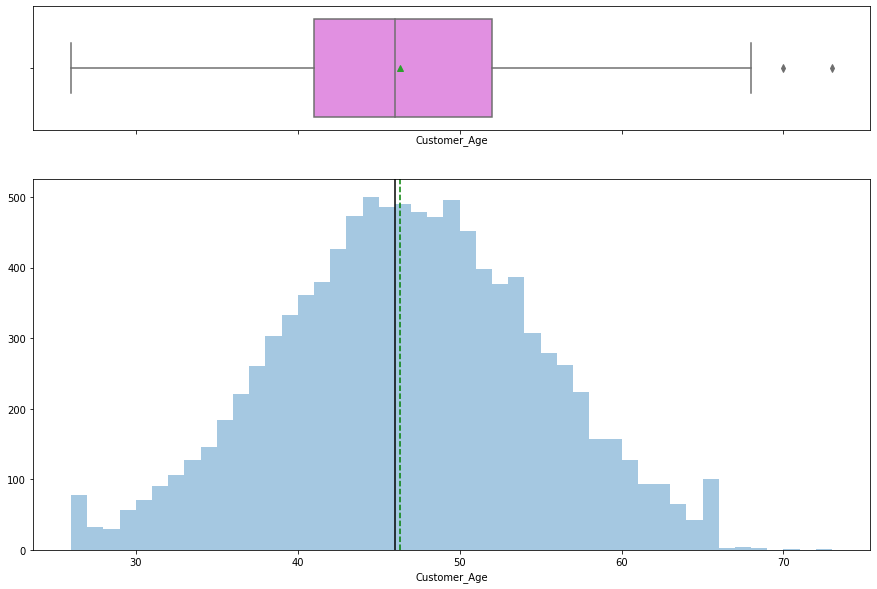

In [ ]:
histogram_boxplot(data['Customer_Age'])

- There are about 2 outliers in Customer_age
- Customer_Age is fairly normally distributed

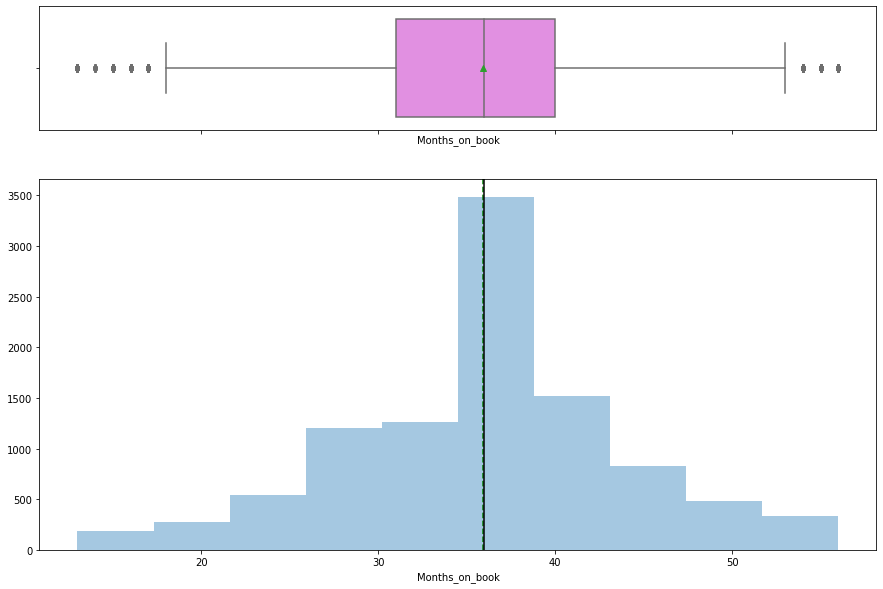

In [ ]:
histogram_boxplot(data['Months_on_book'],bins=10)

- There are a few outliers in Months_on_book
- Months_on_book is normally distributed. Some customers have very short tenure with the bank. Possibly using some credit card features and closing the account

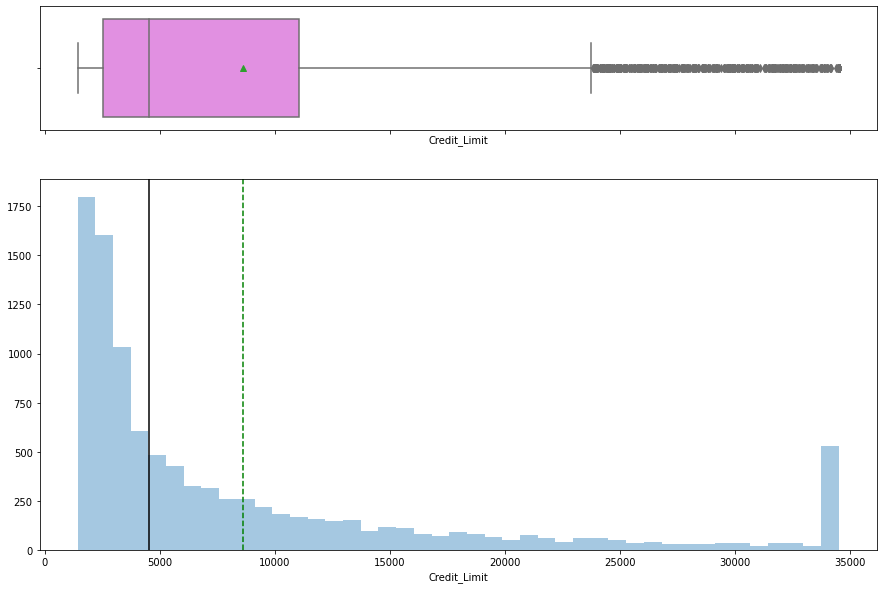

In [ ]:
histogram_boxplot(data['Credit_Limit'])

- Credit_Limit is right skewed
- Depends on a person's credit worthiness. Suppose we can leave this as it is since we can expect this in real world

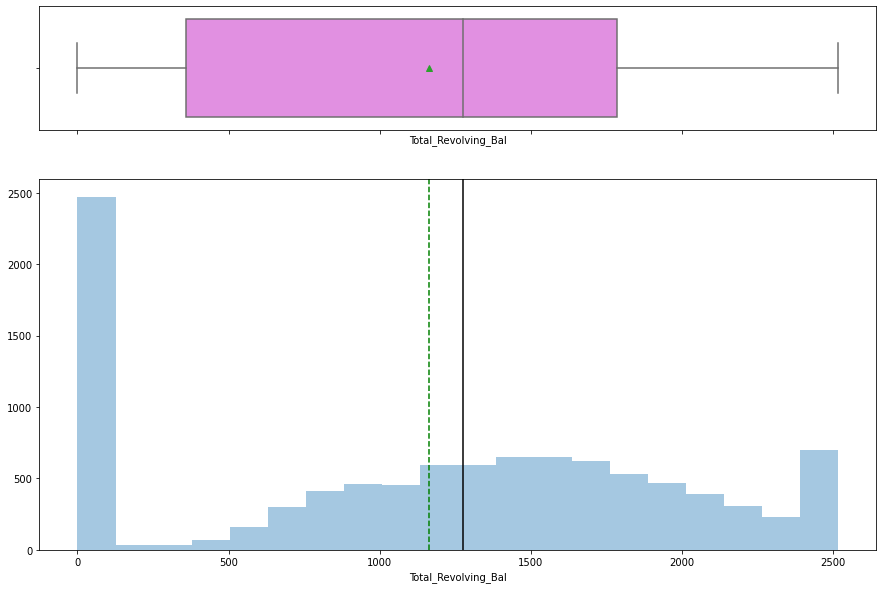

In [ ]:
histogram_boxplot(data['Total_Revolving_Bal'])

- Many customers have 0 Total_Revolving_Bal. Possibly because many of us pay off the monthly charges fully

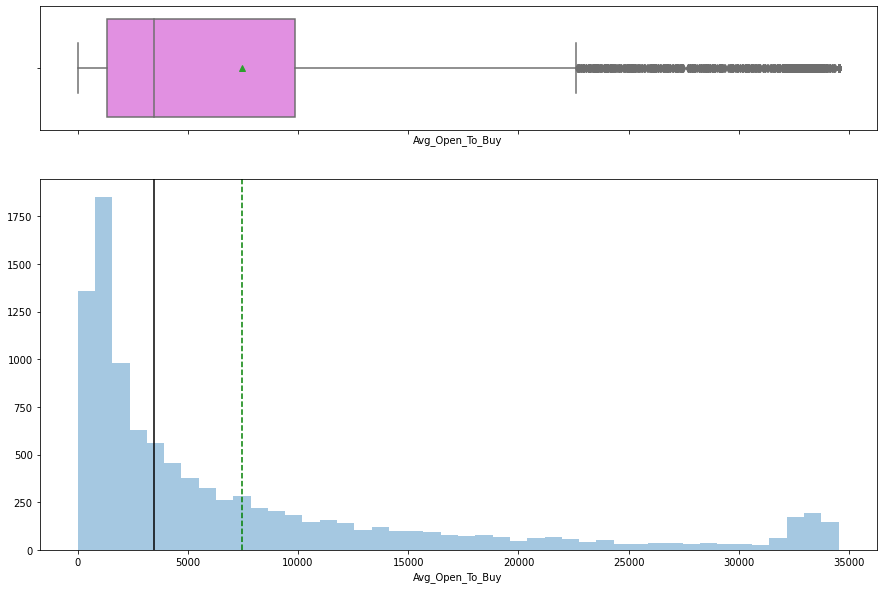

In [ ]:
histogram_boxplot(data['Avg_Open_To_Buy'])

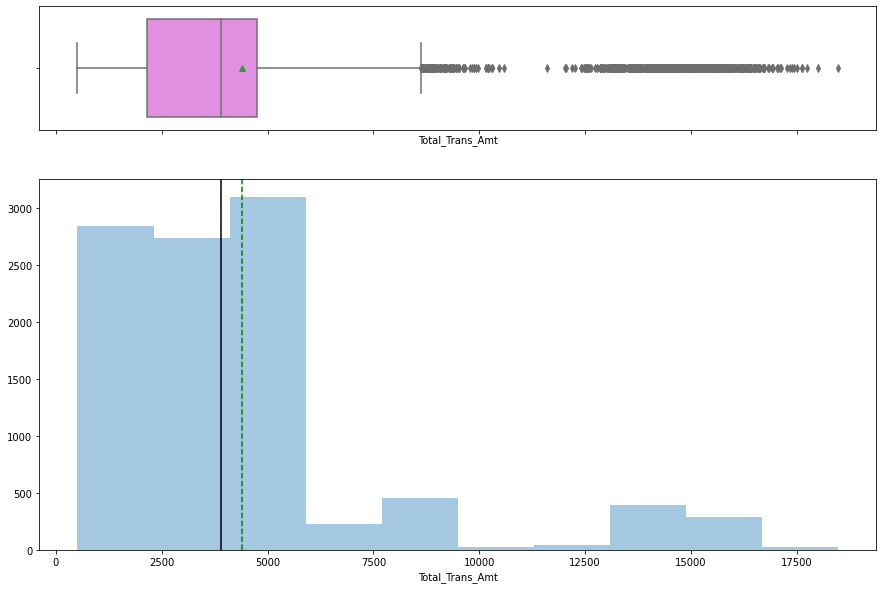

In [ ]:
histogram_boxplot(data['Total_Trans_Amt'],bins=10)

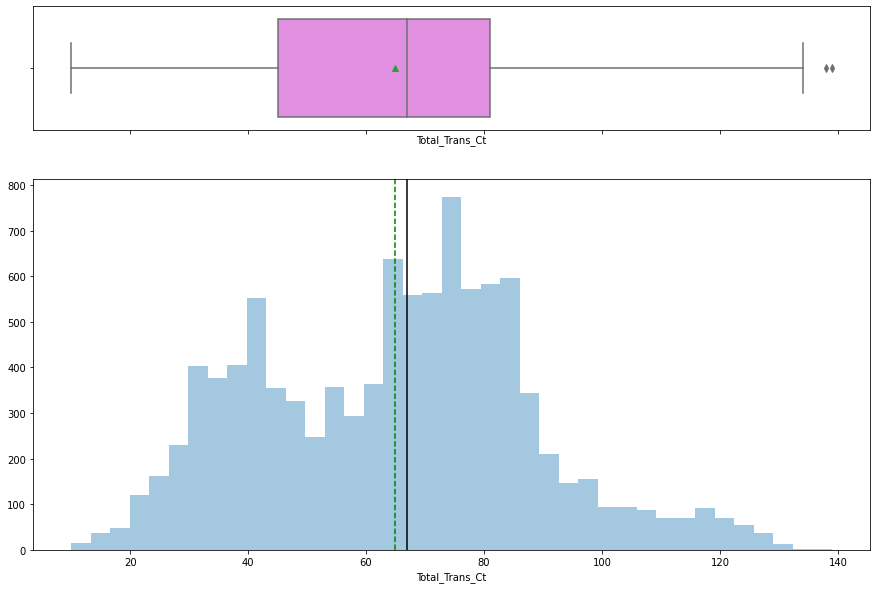

In [ ]:
histogram_boxplot(data['Total_Trans_Ct'])

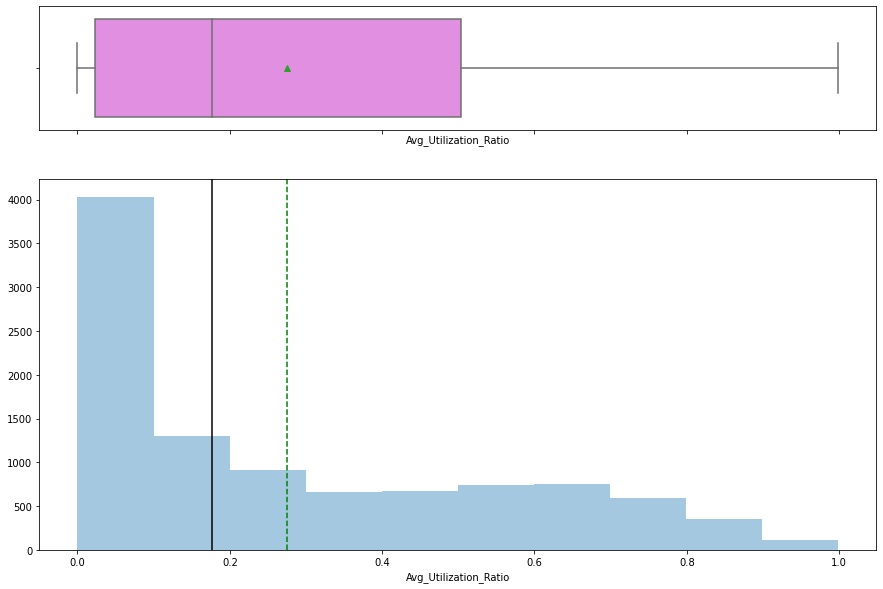

In [ ]:
histogram_boxplot(data['Avg_Utilization_Ratio'],bins=10)

In [ ]:
def bar_chart_perc(feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.countplot(x=feature, data=data)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # height of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot

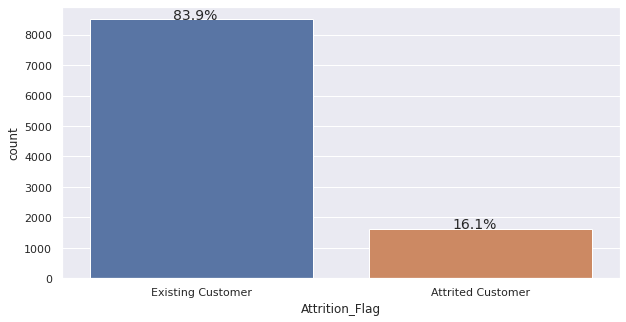

In [ ]:
bar_chart_perc(data['Attrition_Flag'])

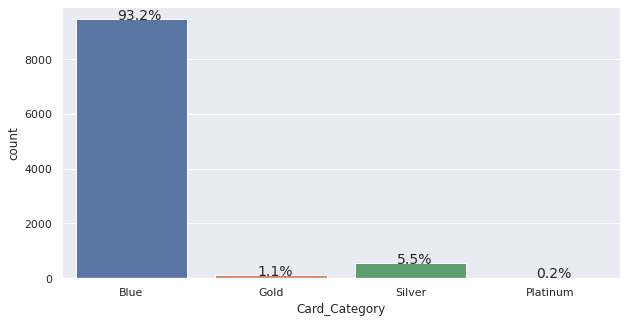

In [ ]:
bar_chart_perc(data['Card_Category'])

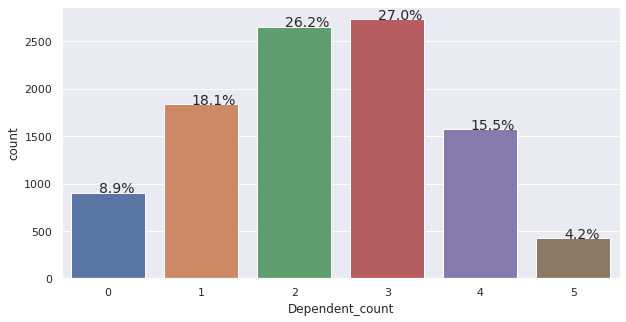

In [ ]:
bar_chart_perc(data['Dependent_count'])

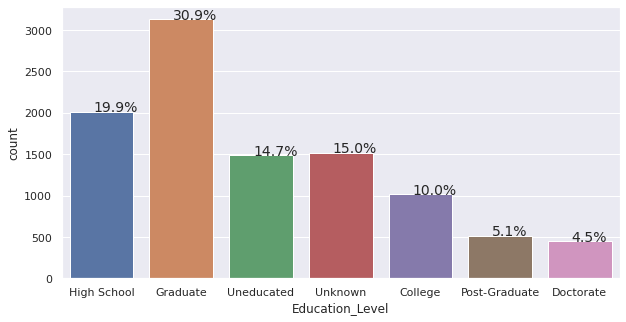

In [ ]:
bar_chart_perc(data['Education_Level'])

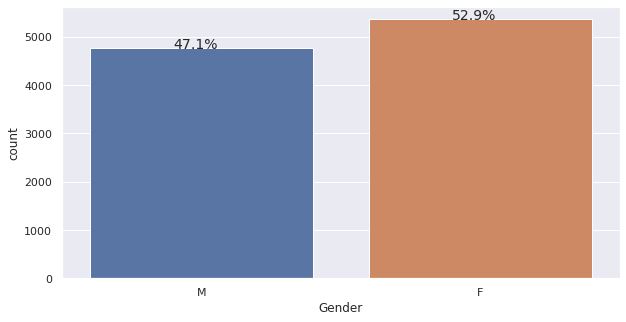

In [ ]:
bar_chart_perc(data['Gender'])

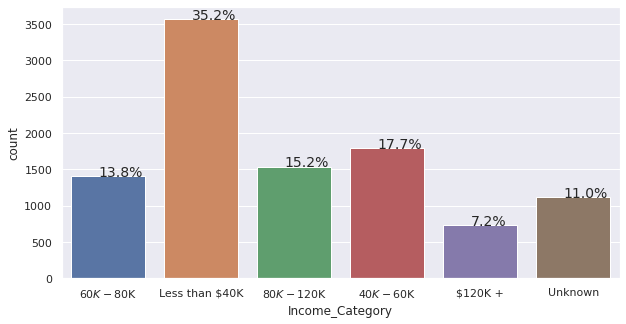

In [ ]:
bar_chart_perc(data['Income_Category'])

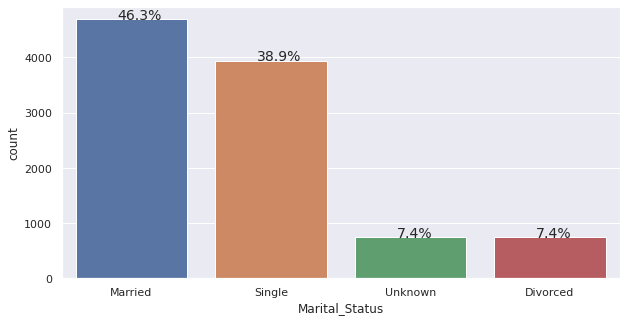

In [ ]:
bar_chart_perc(data['Marital_Status'])

# Bivariate Analysis

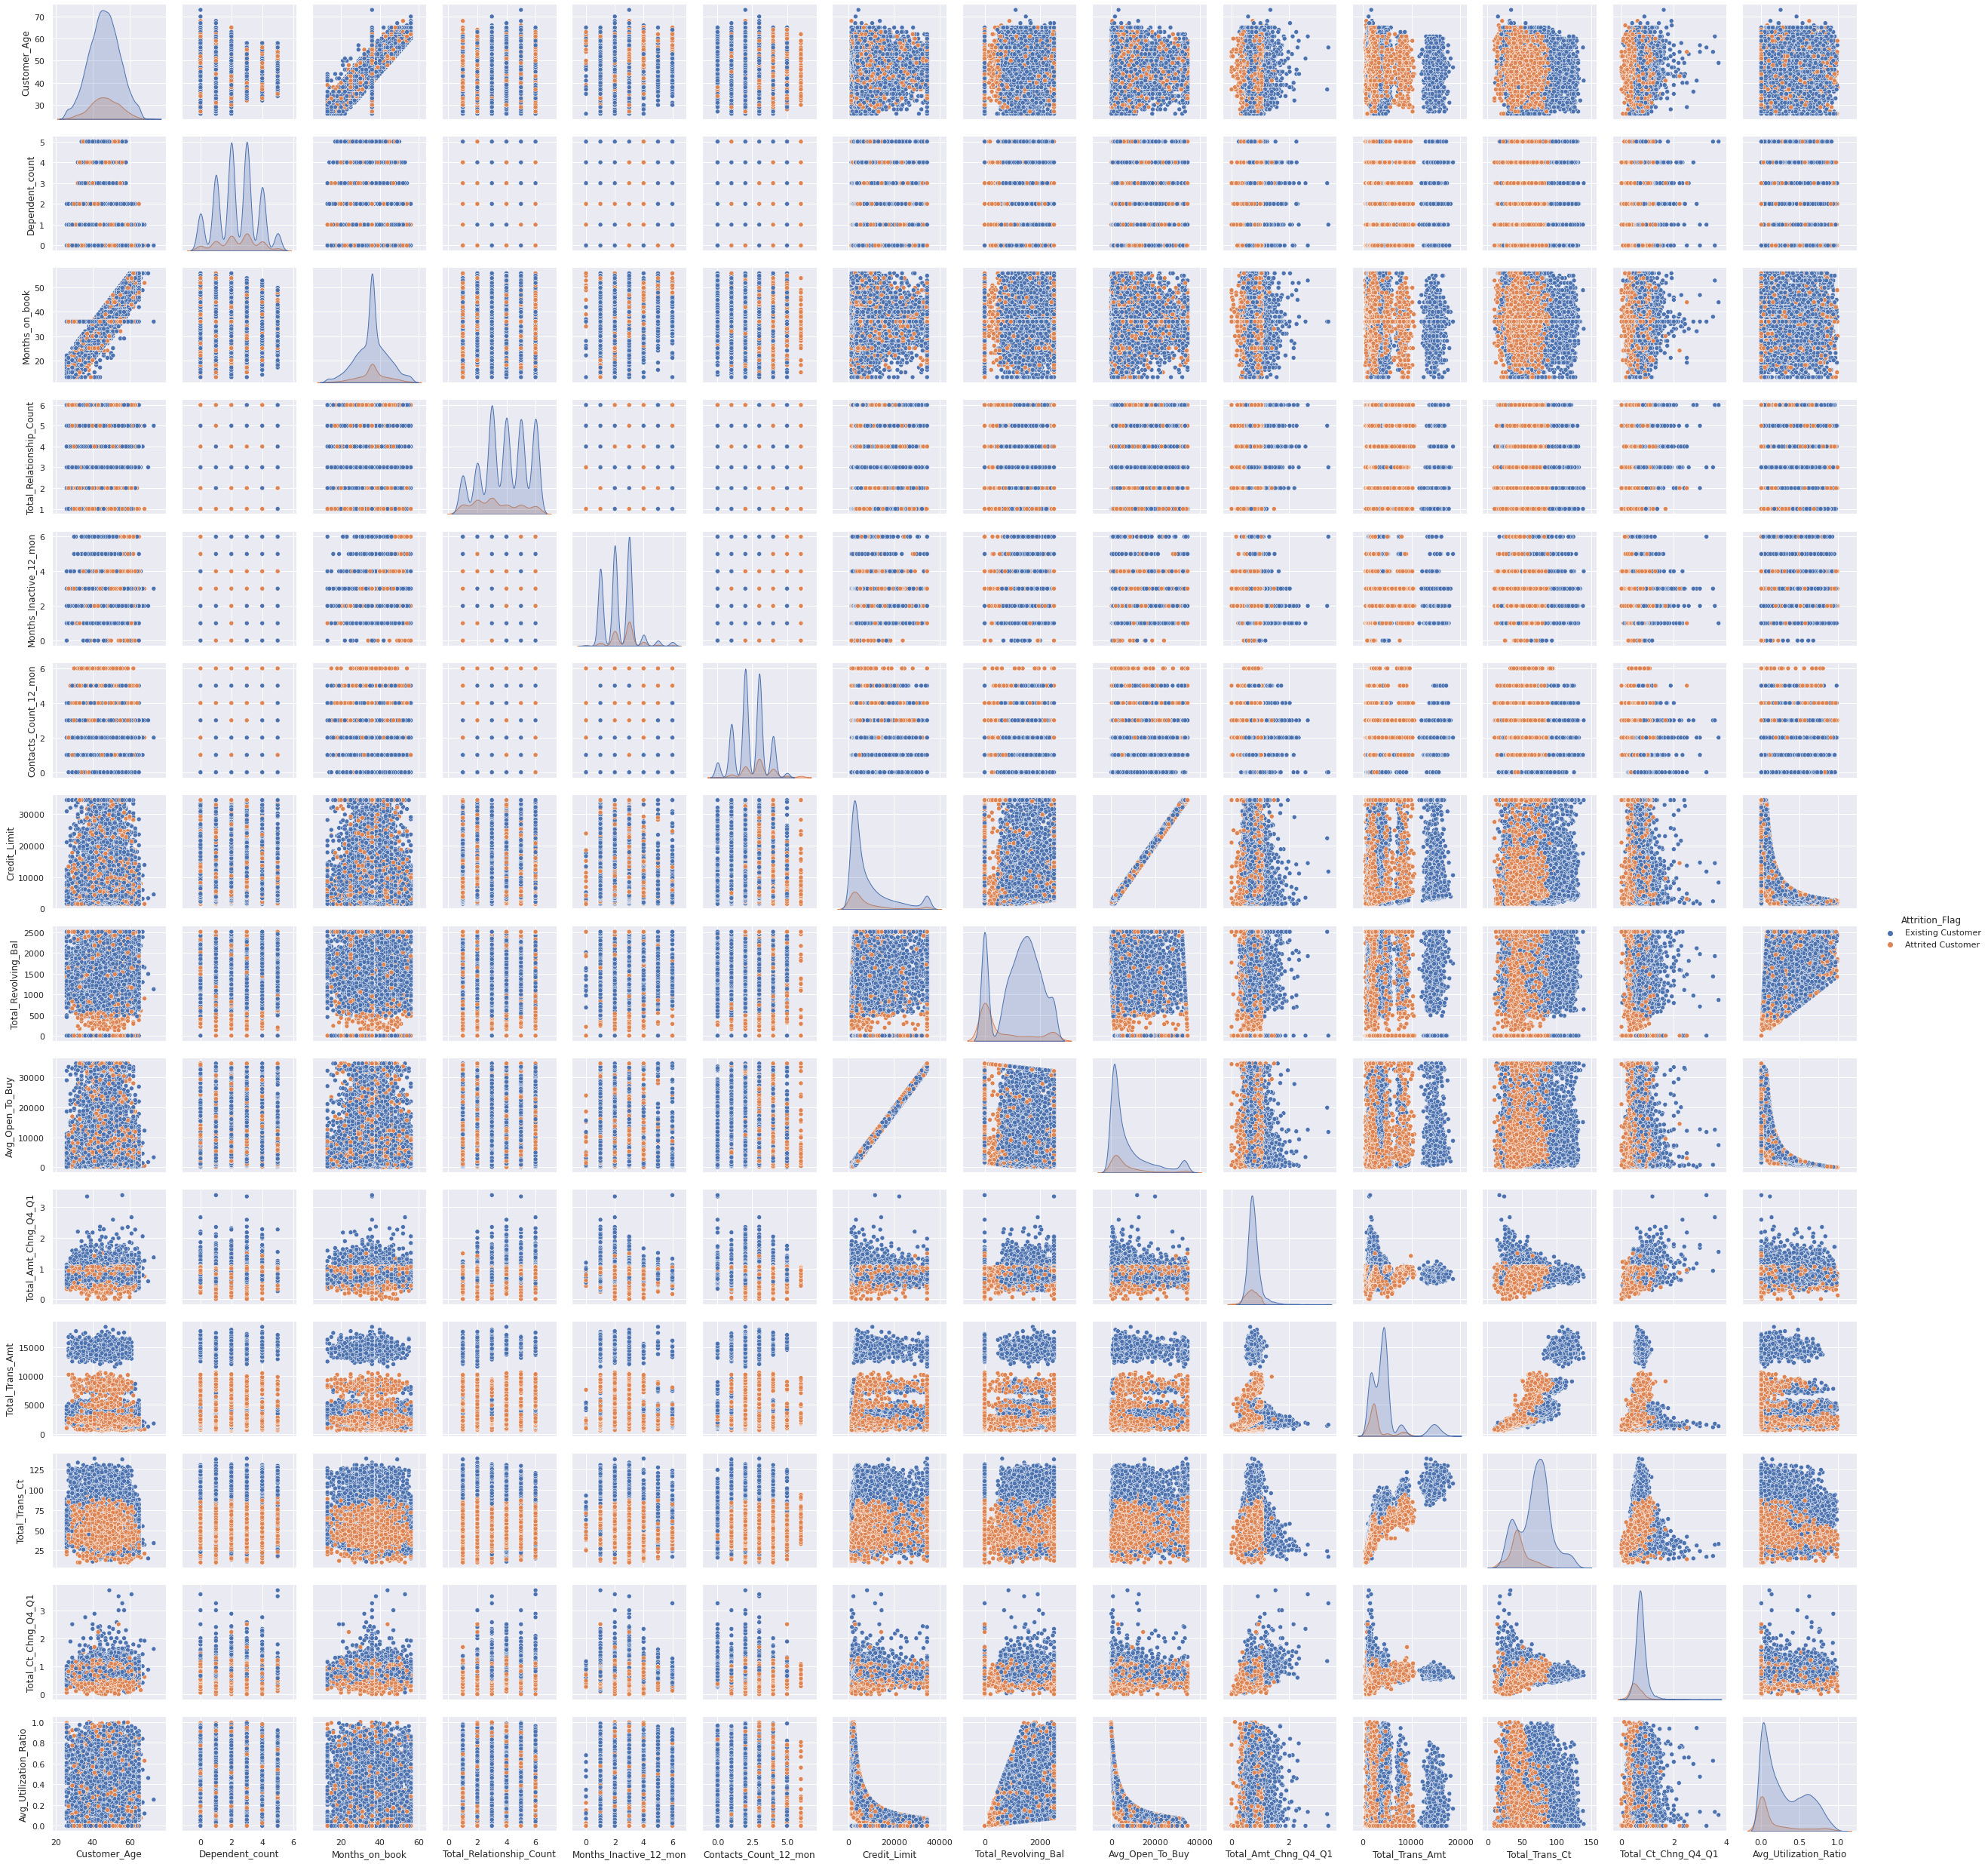

In [ ]:
sns.pairplot(data,hue='Attrition_Flag')

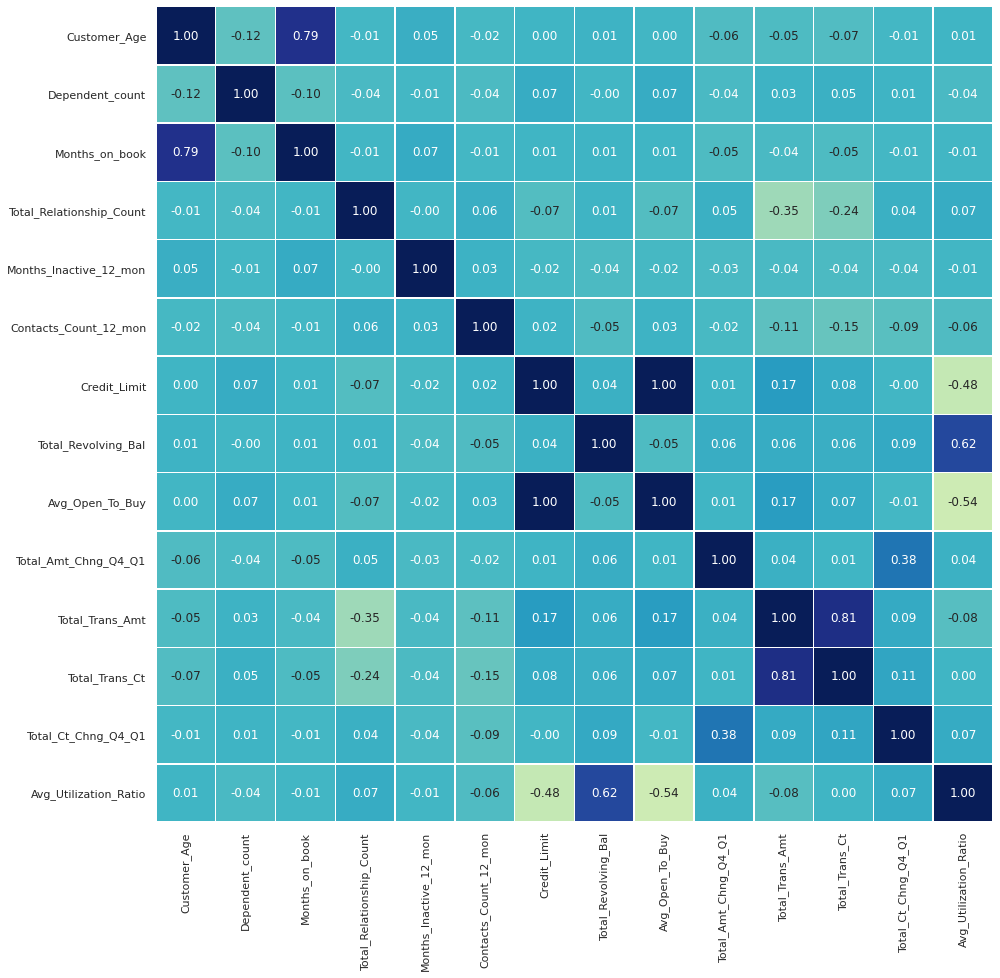

In [ ]:
sns.set(rc={"figure.figsize": (15, 15)})
sns.heatmap(
    data.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

- Customer Age is positively correlated with the period of relationship with the bank
- Credit Limit is negatively correlated with Avg utiization ratio. Its understandable since increase in credit limit will decrease utilization ratio assuming spending/usage doesn't increase
- Total transaction count is also positively correlated with total transaction amount. More transaction means more transaction amount. But this could always be not the case
- Other than the above there is not significant relationship between variables

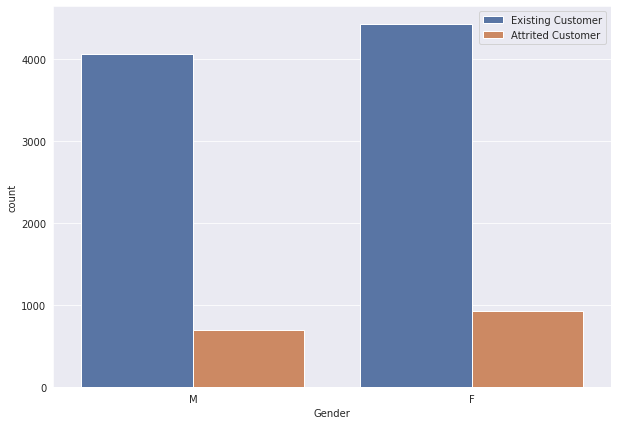

In [ ]:
sns.set({'figure.figsize':(10,7)})
sns.countplot(hue='Attrition_Flag',x='Gender',data=data)
plt.legend()
plt.show()

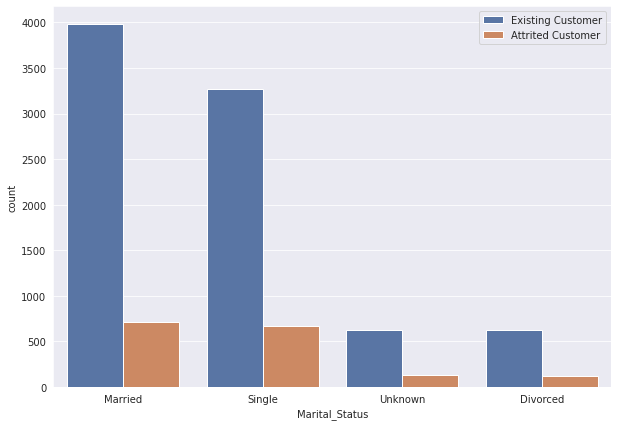

In [ ]:
sns.set({'figure.figsize':(10,7)})
sns.countplot(hue='Attrition_Flag',x='Marital_Status',data=data)
plt.legend()
plt.show()

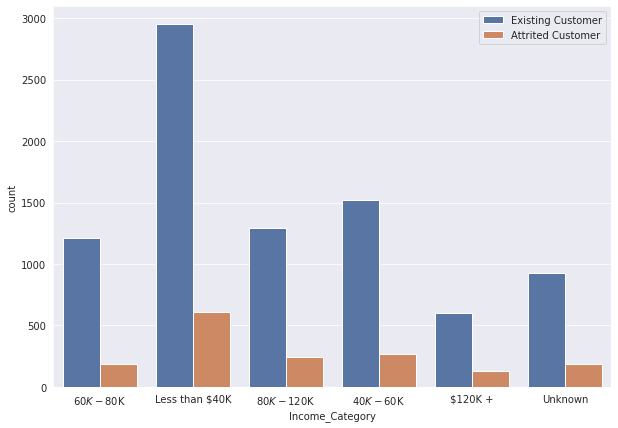

In [ ]:
sns.set({'figure.figsize':(10,7)})
sns.countplot(hue='Attrition_Flag',x='Income_Category',data=data)
plt.legend()
plt.show()

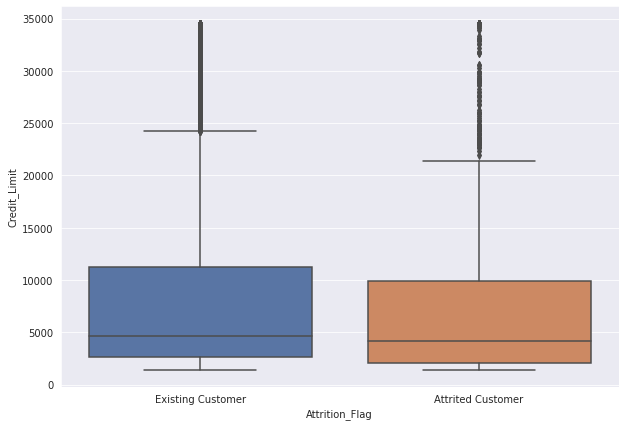

In [ ]:
sns.boxplot(data['Attrition_Flag'], data['Credit_Limit'])
plt.show()

- On an average existing and attrited customers have similar credit limit. So they did not leave because of credit limit

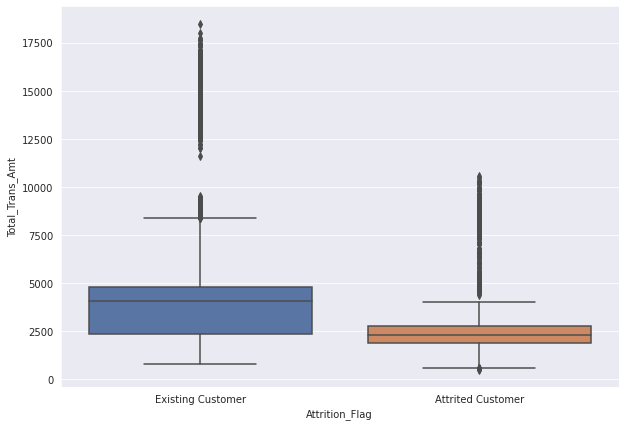

In [ ]:
sns.boxplot(data['Attrition_Flag'], data['Total_Trans_Amt'])
plt.show()

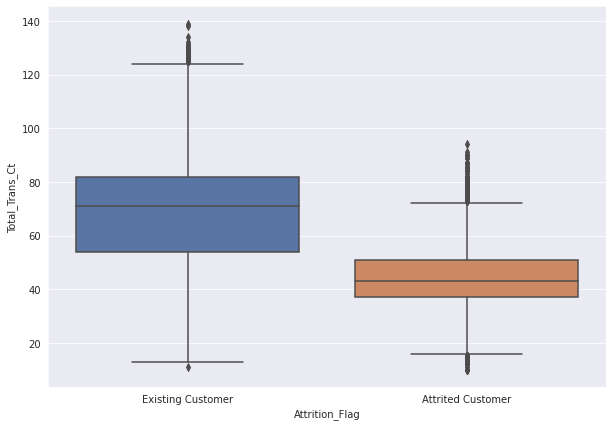

In [ ]:
sns.boxplot(data['Attrition_Flag'], data['Total_Trans_Ct'])
plt.show()

In [ ]:
education = {'Unknown':0,'Uneducated':1,'High School':2,'College':3,'Graduate':4,'Post-Graduate':5,'Doctorate':6}
data['Education_Level'] = data['Education_Level'].map(education)

marital_status = {'Unknown':0,'Single':1,'Married':2,'Divorced':3}
data['Marital_Status'] = data['Marital_Status'].map(marital_status)

attrition_flag = {'Existing Customer':0,'Attrited Customer':1}
data['Attrition_Flag'] = data['Attrition_Flag'].map(attrition_flag)

income = {'Unknown':0,'Less than $40K':1,'$40K - $60K':2,'$60K - $80K':3,'$80K - $120K':4,'$120K +':5}
data['Income_Category'] = data['Income_Category'].map(income)

gender = {'M':0,'F':1}
data['Gender'] = data['Gender'].map(gender)

card_category = {'Blue':0,'Silver':1,'Gold':2,'Platinum':3}
data['Card_Category'] = data['Card_Category'].map(card_category)

In [ ]:
data.head()

Attrition_Flag  Customer_Age  ...  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio
0               0            45  ...                1.625                  0.061
1               0            49  ...                3.714                  0.105
2               0            51  ...                2.333                  0.000
3               0            40  ...                2.333                  0.760
4               0            40  ...                2.500                  0.000

[5 rows x 20 columns]

### Splitting Data and Custom Functions

Lets split the data

In [ ]:
# Separating target variable and other variables
X = data.drop(columns='Attrition_Flag')
Y = data['Attrition_Flag']
seed = 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=seed)
print(X_train.shape, X_test.shape)

(7088, 19) (3039, 19)


Encoding Categorical Variable

In [ ]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.shape, X_test.shape)

(7088, 19) (3039, 19)


In [ ]:
def confusion_matrix(model,y_actual,label=[0,1]):
    y_pred = model.predict(X_test)
    confmatrix = metrics.confusion_matrix(y_actual, y_pred, labels=[0, 1])
    confmatrix_df = pd.DataFrame(confmatrix, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                confmatrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confmatrix.flatten()/np.sum(confmatrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(confmatrix_df, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def model_score(model,flag=True):
    #list to store train and test results
    score_list = []
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    acc_train = model.score(X_train,y_train)
    acc_test = model.score(X_test,y_test)
    
    recall_train = metrics.recall_score(y_train,pred_train)
    recall_test = metrics.recall_score(y_test,pred_test)
    
    precision_train = metrics.precision_score(y_train,pred_train)
    precision_test = metrics.precision_score(y_test,pred_test)
    
    #r2_train = metrics.r2_score(y_train,pred_train)
    #r2_test = metrics.r2_score(y_test,pred_test)
    
    #rmse_train = np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    #rmse_test = np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    score_list.extend((acc_train,acc_test,recall_train,recall_test,precision_train,precision_test))
    
    if flag == True: 
        print("Accuracy on training set : ",acc_train)
        print("Accuracy on test set : ",acc_test)
        print("Recall on training set : ",recall_train)
        print("Recall on test set : ",recall_test)
        print("Precision on training set : ",precision_train)
        print("Precision on test set : ",precision_test)
        
    return score_list

## Models

Base Model

In [ ]:
model_LogReg = LogisticRegression(random_state=seed)
model_LogReg.fit(X_train,y_train)

y_predict = model_LogReg.predict(X_test)

In [ ]:
model_LogReg_Base_Score = model_score(model_LogReg)

Accuracy on training set :  0.8727426636568849
Accuracy on test set :  0.8726554787759131
Recall on training set :  0.42395104895104896
Recall on test set :  0.42650103519668736
Precision on training set :  0.6662087912087912
Precision on test set :  0.6518987341772152


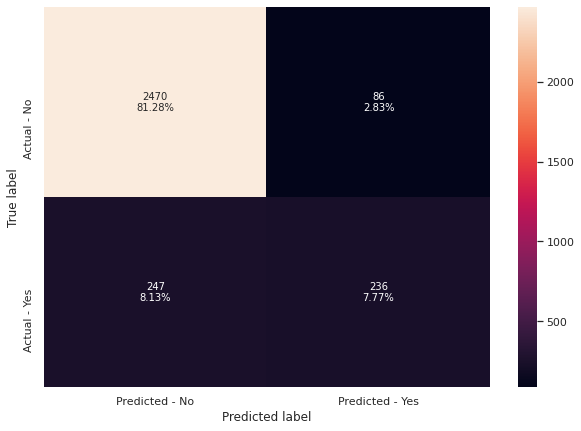

In [ ]:
confusion_matrix(model_LogReg,y_test)

- Recall score on base model is at 0.49 which is close to training set

### Using SMOTE for Up-Sampling

In [ ]:
print("Before UpSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=seed)   #Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

print('After UpSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

Before UpSampling, counts of label '1': 1144
Before UpSampling, counts of label '0': 5944 

After UpSampling, counts of label '1': 5944
After UpSampling, counts of label '0': 5944 

After UpSampling, the shape of train_X: (11888, 19)
After UpSampling, the shape of train_y: (11888,) 



In [ ]:
model_LogReg.fit(X_train_res, y_train_res)
y_predict = model_LogReg.predict(X_test)
model_LogReg_Upsample_score = model_score(model_LogReg)


Accuracy on training set :  0.7975451467268623
Accuracy on test set :  0.7943402435011517
Recall on training set :  0.798951048951049
Recall on test set :  0.8095238095238095
Precision on training set :  0.43133553563001414
Precision on test set :  0.4231601731601732


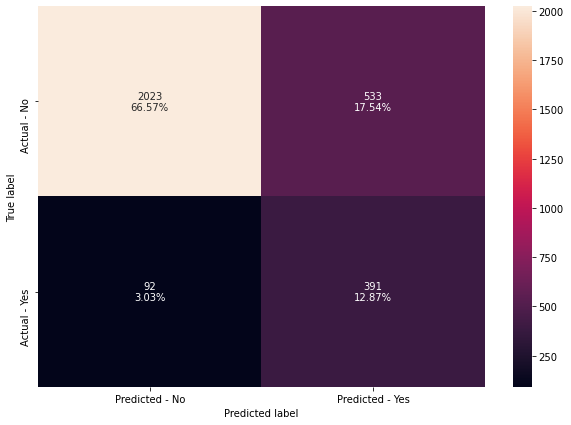

In [ ]:
confusion_matrix(model_LogReg,y_test)

WIth upsampling using SMOTE, recall has increased to 0.8. However, accuracy and precision have gone down

### Down Sampling larger class

In [ ]:
att_flag = data[data['Attrition_Flag'] == 0].index   
att_flag_len = len(data[data['Attrition_Flag'] == 0])             
print(att_flag_len)

non_att_flag = data[data['Attrition_Flag'] == 1].index       
non_att_flag_len = len(data[data['Attrition_Flag'] == 1])                
print(non_att_flag_len)

8500
1627


In [ ]:
random_indices = np.random.choice(att_flag, att_flag_len - 200 , replace=False)

In [ ]:
down_sample_indices = np.concatenate([non_att_flag,random_indices]) 

In [ ]:
data_down_sample = data.loc[down_sample_indices]
data_down_sample.shape
data_down_sample.groupby(['Attrition_Flag']).count()

Customer_Age  ...  Avg_Utilization_Ratio
Attrition_Flag                ...                       
0                       8300  ...                   8300
1                       1627  ...                   1627

[2 rows x 19 columns]

In [ ]:
X_DownSample = data_down_sample.drop(columns='Attrition_Flag')
Y_DownSample = data_down_sample['Attrition_Flag']

In [ ]:
X_train_DownSample, X_test_DownSample, y_train_DownSample, y_test_DownSample = train_test_split(X_DownSample, Y_DownSample, test_size=0.30, random_state=seed)
print(X_train_DownSample.shape, X_test_DownSample.shape)

(6948, 19) (2979, 19)


In [ ]:
print('After DownSampling, the shape of X_train: {}'.format(X_train_DownSample.shape))
print('After DownSampling, the shape of X_test: {} \n'.format(X_test_DownSample.shape))

After DownSampling, the shape of X_train: (6948, 19)
After DownSampling, the shape of X_test: (2979, 19) 



In [ ]:
model_LogReg.fit(X_train_DownSample, y_train_DownSample)
y_predict = model_LogReg.predict(X_test_DownSample)
model_LogReg_Downsample_score = model_score(model_LogReg)

Accuracy on training set :  0.8875564334085779
Accuracy on test set :  0.8858177031918394
Recall on training set :  0.4938811188811189
Recall on test set :  0.474120082815735
Precision on training set :  0.7215836526181354
Precision on test set :  0.7111801242236024


Downsampling didn't really help with recall score. In fact it has gone down

## Bagging Classifier

In [ ]:
bagging_estimator = BaggingClassifier(random_state=seed)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

Accuracy on training set :  0.9964729119638827
Accuracy on test set :  0.9536031589338598
Recall on training set :  0.9781468531468531
Recall on test set :  0.8219461697722568
Precision on training set :  1.0
Precision on test set :  0.8783185840707964


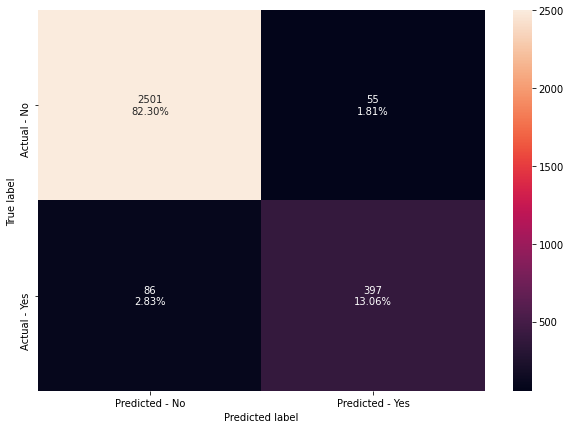

In [ ]:
bagging_estimator_score = model_score(bagging_estimator)
confusion_matrix(bagging_estimator,y_test)

#### Hyperparameter Tuning

##### GridSearchCV

In [ ]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=seed))

# Parameter grid to pass in GridSearchCV

param_grid = {
              'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
              'baggingclassifier__max_features': [0.7,0.8,0.9,1],
              'baggingclassifier__n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'baggingclassifier__max_features': 0.9, 'baggingclassifier__max_samples': 0.7, 'baggingclassifier__n_estimators': 50} 
Score: 0.8418256339538803
CPU times: user 2min 53s, sys: 658 ms, total: 2min 53s
Wall time: 2min 53s


In [ ]:
#Final pipeline with best parameters
bagging_tuned1 = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.9,
        max_samples=0.7,
        random_state=seed,
        n_estimators=50,
    ),
)

# Fit the model on training data
bagging_tuned1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=0.9,
                                   max_samples=0.7, n_estimators=50,
                                   n_jobs=None, oob_score=False, random_state=2,
                                   verbose=0, warm_start=False))],
         verbose=False)

Accuracy on training set :  0.9977426636568849
Accuracy on test set :  0.9615004935834156
Recall on training set :  0.9895104895104895
Recall on test set :  0.8385093167701864
Precision on training set :  0.9964788732394366
Precision on test set :  0.9121621621621622


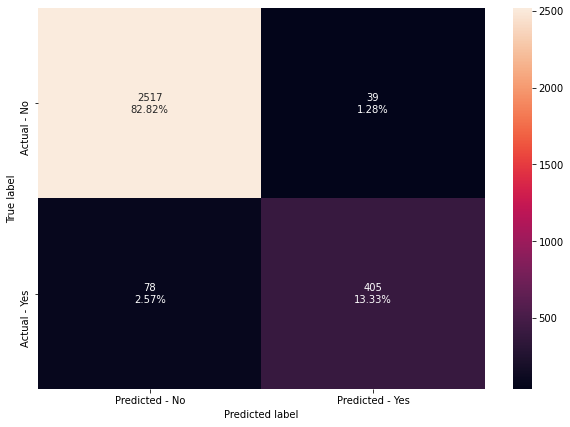

In [ ]:
bagging_tuned1_score = model_score(bagging_tuned1)
confusion_matrix(bagging_tuned1,y_test)

##### RandomizedSearchCV

In [ ]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# Parameter grid to pass in RandomSearchCV
param_grid = {
              'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
              'baggingclassifier__max_features': [0.7,0.8,0.9,1],
              'baggingclassifier__n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'baggingclassifier__n_estimators': 50, 'baggingclassifier__max_samples': 0.7, 'baggingclassifier__max_features': 0.9} with CV score=0.8418256339538803:
CPU times: user 1min 46s, sys: 350 ms, total: 1min 46s
Wall time: 1min 46s


In [ ]:
# Creating new pipeline with best parameters
bagging_tuned2 = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.8,
        random_state=1,
        max_samples=0.7,
        n_estimators=50
    ),
)

# Fit the model on training data
bagging_tuned2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=0.8,
                                   max_samples=0.7, n_estimators=50,
                                   n_jobs=None, oob_score=False, random_state=1,
                                   verbose=0, warm_start=False))],
         verbose=False)

Accuracy on training set :  0.9980248306997742
Accuracy on test set :  0.9661072721289898
Recall on training set :  0.9877622377622378
Recall on test set :  0.8509316770186336
Precision on training set :  1.0
Precision on test set :  0.9298642533936652


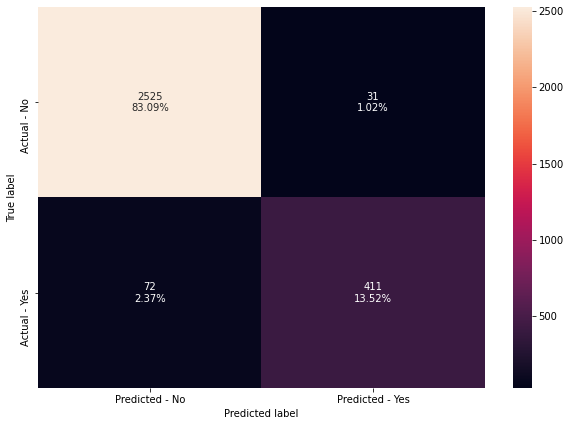

In [ ]:
bagging_tuned2_score = model_score(bagging_tuned2)
confusion_matrix(bagging_tuned2,y_test)

- Bagging Classifier is almost overfitting the data
- Recall on test set is lesser than the training set
- Even with hyperparameter tuning, there is overfitting of the data

## Random Forest Classifier

In [ ]:
rand_forest_estimator = RandomForestClassifier(random_state=seed)
rand_forest_estimator.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Accuracy on training set :  1.0
Accuracy on test set :  0.9595261599210266
Recall on training set :  1.0
Recall on test set :  0.8012422360248447
Precision on training set :  1.0
Precision on test set :  0.9347826086956522


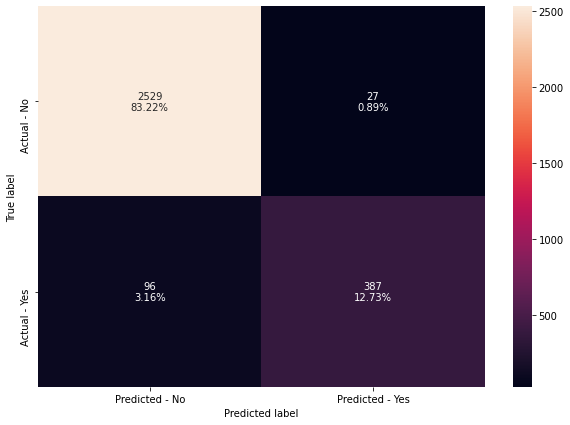

In [ ]:
rand_forest_score = model_score(rand_forest_estimator)
confusion_matrix(rand_forest_estimator,y_test)

### Hyperparamenter tuning

##### GridSearchCV

In [ ]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV

param_grid = {
    "randomforestclassifier__n_estimators": [100,150,250],
    "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
    "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
    "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_samples': 0.5000000000000001, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 150} 
Score: 0.7875699073010036
CPU times: user 8min 34s, sys: 1.42 s, total: 8min 36s
Wall time: 8min 36s


In [ ]:
# Creating new pipeline with best parameters
randforest_tuned1 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_features='sqrt',
        random_state=1,
        max_samples=0.5000000000000001,
        min_samples_leaf=1
    ),
)

# Fit the model on training data
randforest_tuned1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None,
                                        max_samples=0.5000000000000001,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=1,
                                       

Accuracy on training set :  0.9942155756207675
Accuracy on test set :  0.9568937150378414
Recall on training set :  0.9659090909090909
Recall on test set :  0.7908902691511387
Precision on training set :  0.998193315266486
Precision on test set :  0.9271844660194175


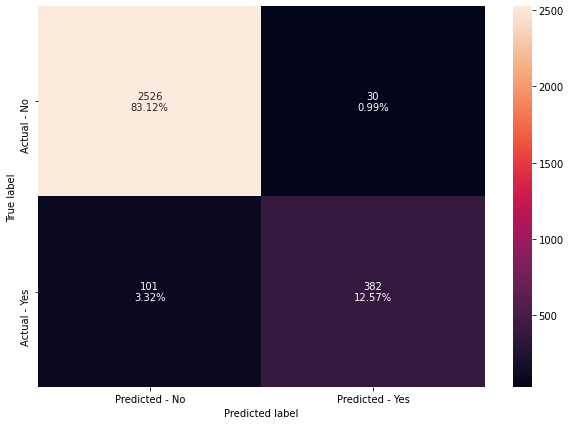

In [ ]:
randforest_tuned1_score = model_score(randforest_tuned1)
confusion_matrix(randforest_tuned1,y_test)

##### RandomizedSearchCV

In [ ]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "randomforestclassifier__n_estimators": [100,150,250],
    "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
    "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
    "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_samples': 0.5000000000000001, 'randomforestclassifier__max_features': 'sqrt'} with CV score=0.7875699073010036:
CPU times: user 2min 4s, sys: 369 ms, total: 2min 4s
Wall time: 2min 4s


In [ ]:
# Creating new pipeline with best parameters
randforest_tuned2 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=150,
        max_features='sqrt',
        random_state=1,
        max_samples=0.5000000000000001,
        min_samples_leaf=1
    ),
)

# Fit the model on training data
randforest_tuned2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None,
                                        max_samples=0.5000000000000001,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=1,
                                       

Accuracy on training set :  0.9942155756207675
Accuracy on test set :  0.9568937150378414
Recall on training set :  0.9659090909090909
Recall on test set :  0.7908902691511387
Precision on training set :  0.998193315266486
Precision on test set :  0.9271844660194175


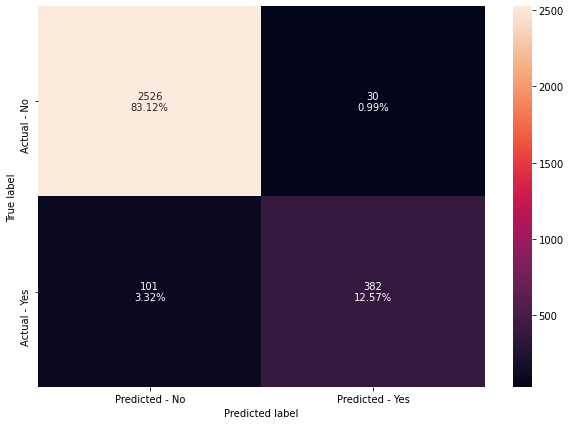

In [ ]:
randoforest_tuned2_score = model_score(randforest_tuned2)
confusion_matrix(randforest_tuned2,y_test)

- Random Forest is defintely overfitting the data
- Hyperparameter tuning did not give any better results
- Test recall is still low

### Model Building using K-fold CV

In [ ]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(
    (
        "LR",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg", LogisticRegression(random_state=seed)),
            ]
        ),
    )
)
models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=seed)),
            ]
        ),
    )
)
models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=seed)),
            ]
        ),
    )
)
models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=seed)),
            ]
        ),
    )
)
models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=seed,eval_metric='logloss')),
            ]
        ),
    )
)
models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=seed)),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=seed
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR: 59.08756607676396
RF: 81.46632957940703
GBM: 84.61541408105417
ADB: 85.14019765571132
XGB: 84.5269286754003
DTREE: 80.59105186547153


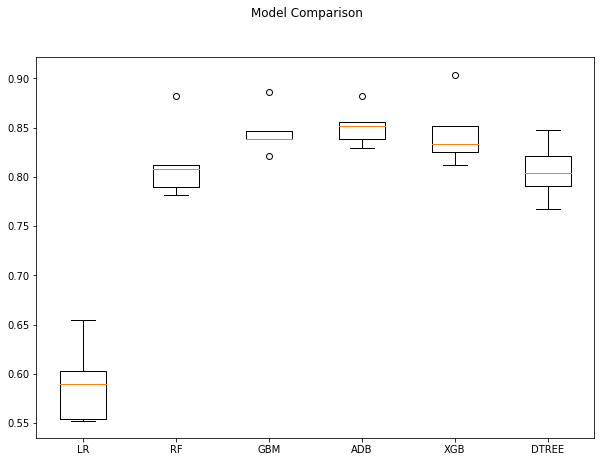

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- Adaboost has the highest cross validated score with 85%
- Gradient Boosting and XG Boosting are fairly closer to Adaboost

## AdaBoost

##### GridSearchCV

In [ ]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=seed))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=seed),
        DecisionTreeClassifier(max_depth=2, random_state=seed),
        DecisionTreeClassifier(max_depth=3, random_state=seed),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'adaboostclassifier__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best'), 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 60} 
Score: 0.8820003064429633
CPU times: user 10min 30s, sys: 2.37 s, total: 10min 33s
Wall time: 10min 32s


In [ ]:
# Creating new pipeline with best parameters
abc_tuned1 = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2, random_state=seed),
        n_estimators=100,
        learning_rate=1,
        random_state=seed,
    ),
)

# Fit the model on training data
abc_tuned1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=2,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                                                                          min_impurity_decrease=0.0,
                                                                          min_impurity_split=None,
                      

Accuracy on training set :  0.9964729119638827
Accuracy on test set :  0.9647910496873972
Recall on training set :  0.9868881118881119
Recall on test set :  0.8633540372670807
Precision on training set :  0.9912203687445127
Precision on test set :  0.9104803493449781


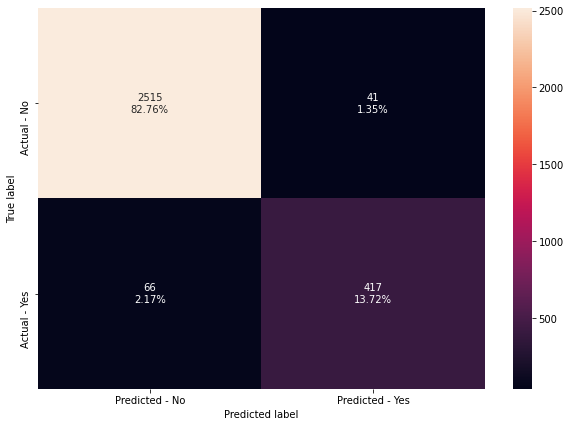

In [ ]:
abc_tuned1_score = model_score(abc_tuned1)
confusion_matrix(abc_tuned1,y_test)

- Accuracy is close to 1. Model is overfitting the data
- There is not much improvement in tuned model as compared to base model

##### RandomizedSearchCV

In [ ]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=seed))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=seed),
        DecisionTreeClassifier(max_depth=2, random_state=seed),
        DecisionTreeClassifier(max_depth=3, random_state=seed),
    ],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
abc_tuned2 = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=seed)

#Fitting parameters in RandomizedSearchCV
abc_tuned2.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(abc_tuned2.best_params_,abc_tuned2.best_score_))

Best parameters are {'adaboostclassifier__n_estimators': 100, 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')} with CV score=0.8767677928445569:
CPU times: user 3min 41s, sys: 703 ms, total: 3min 42s
Wall time: 3min 41s


Accuracy on training set :  0.9868881118881119
Accuracy on test set :  0.8633540372670807
Recall on training set :  0.9868881118881119
Recall on test set :  0.8633540372670807
Precision on training set :  0.9912203687445127
Precision on test set :  0.9104803493449781


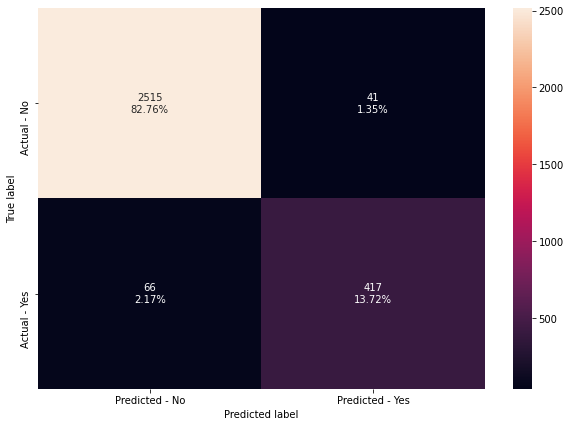

In [ ]:
abc_tuned2_score = model_score(abc_tuned2)
confusion_matrix(abc_tuned2,y_test)

- RandomizedSearchCV definitely ran much faster (took 1/3rd time of GridSearch)
- Model is still overfitting the data
- We don't see a significant improvement in recall score

## GBM

##### GridSearchCV

In [ ]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "gradientboostingclassifier__init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "gradientboostingclassifier__n_estimators": np.arange(75,150,25),
    "gradientboostingclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "gradientboostingclassifier__subsample":[0.5,0.7,1],
    "gradientboostingclassifier__max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'gradientboostingclassifier__init': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1), 'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__max_features': 0.7, 'gradientboostingclassifier__n_estimators': 125, 'gradientboostingclassifier__subsample': 1} 
Score: 0.877633494215889
CPU times: user 15min 18s, sys: 1.58 s, total: 15min 20s
Wall time: 15min 19s


In [ ]:
# Creating new pipeline with best parameters
gbc_tuned1 = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        init=AdaBoostClassifier(random_state=1),
        learning_rate=1,
        max_features=0.7,
        n_estimators=125,
        subsample=1,
        random_state=seed,
    ),
)

# Fit the model on training data
gbc_tuned1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse',
                                            init=AdaBoostClassifier(algorithm='SAMME.R',
                                                                    base_estimator=None,
                                                                    learning_rate=1.0,
                                                                    n_estimators=50,
                                                                    random_state=1),
                                            learning_rate=1, loss='deviance',
                                            max_depth=3, max_features=0.7,
                                            max_leaf_nodes=None,
                                      

Accuracy on training set :  0.9978837471783296
Accuracy on test set :  0.9651201052977953
Recall on training set :  0.993006993006993
Recall on test set :  0.8716356107660456
Precision on training set :  0.9938757655293088
Precision on test set :  0.9053763440860215


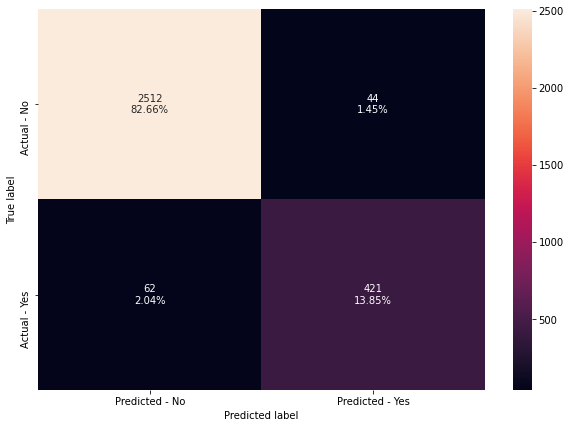

In [ ]:
gbc_tuned1_score = model_score(gbc_tuned1)
confusion_matrix(gbc_tuned1,y_test)

##### RandomizedSearchCV

In [ ]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),GradientBoostingClassifier(random_state=1))

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "gradientboostingclassifier__init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "gradientboostingclassifier__n_estimators": np.arange(75,150,25),
    "gradientboostingclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "gradientboostingclassifier__subsample":[0.5,0.7,1],
    "gradientboostingclassifier__max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'gradientboostingclassifier__subsample': 0.7, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__max_features': 0.5, 'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__init': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)} with CV score=0.8697617405960315:
CPU times: user 2min 46s, sys: 317 ms, total: 2min 46s
Wall time: 2min 46s


In [ ]:
# Creating new pipeline with best parameters
gbc_tuned2 = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        init=AdaBoostClassifier(random_state=1),
        learning_rate=0.2,
        max_features=0.5,
        n_estimators=100,
        subsample=0.7,
        random_state=seed,
    ),
)

# Fit the model on training data
gbc_tuned2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse',
                                            init=AdaBoostClassifier(algorithm='SAMME.R',
                                                                    base_estimator=None,
                                                                    learning_rate=1.0,
                                                                    n_estimators=50,
                                                                    random_state=1),
                                            learning_rate=0.2, loss='deviance',
                                            max_depth=3, max_features=0.5,
                                            max_leaf_nodes=None,
                                    

Accuracy on training set :  0.9858916478555305
Accuracy on test set :  0.9703849950641659
Recall on training set :  0.9414335664335665
Recall on test set :  0.8716356107660456
Precision on training set :  0.9702702702702702
Precision on test set :  0.9376391982182628


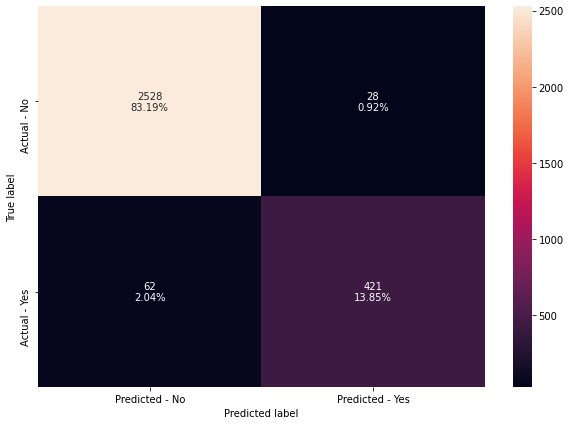

In [ ]:
gbc_tuned2_score = model_score(gbc_tuned2)
confusion_matrix(gbc_tuned2,y_test)

## XGBoost

##### Grid Search

In [ ]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=seed,eval_metric='logloss'))

#Parameter grid to pass in GridSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

#Fitting parameters in GridSeachCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

KeyboardInterrupt: ignored

- Mistakenly ran GridSearchCV again. So the result disappeared. I have pasted the result from the revision history below:

Execution output from Apr 11, 2021 2:03 AM
	Stream
		Best parameters are {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__subsample': 0.7} with CV score=0.9720447406726423:
		CPU times: user 1h 11min 40s, sys: 22.3 s, total: 1h 12min 3s
		Wall time: 1h 11min 47s

In [ ]:
# Creating new pipeline with best parameters
xgb_tuned1 = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=seed,
        n_estimators=150,
        scale_pos_weight=10,
        subsample=0.7,
        learning_rate=0.01,
        gamma=0,
        eval_metric='logloss',
    ),
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, learning_rate=0.01, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=None,
                               n_estimators=150, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               seed=None, silent=None, subsample=0.7,
                               verbosity=1))],
         verbose=False)

Accuracy on training set :  0.8105248306997742
Accuracy on test set :  0.790720631786772
Recall on training set :  0.9807692307692307
Recall on test set :  0.9772256728778468
Precision on training set :  0.45927138763814984
Precision on test set :  0.43026435733819507


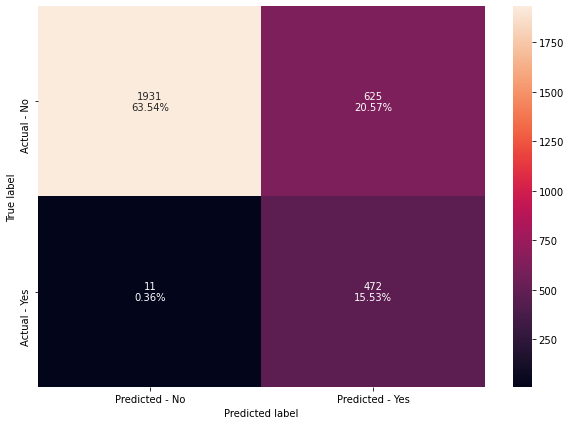

In [ ]:
xgb_tuned1_score = model_score(xgb_tuned1)
confusion_matrix(xgb_tuned1,y_test)

##### RandomizedSearchCV

In [ ]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=seed,eval_metric='logloss', n_estimators = 50))

#Parameter grid to pass in GridSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05],
            'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1],
           'xgbclassifier__max_depth':np.arange(1,10,1),
            'xgbclassifier__reg_lambda':[0,1,2,5,10]}





# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=seed)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

In [ ]:
# Creating new pipeline with best parameters
xgb_tuned2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "XGB",
            XGBClassifier(
                random_state=seed,
                n_estimators=250,
                scale_pos_weight=10,
                gamma=1,
                subsample=1,
                learning_rate= 0.05,
                eval_metric='logloss', max_depth = 1, reg_lambda = 2
            ),
        ),
    ]
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

Accuracy on training set :  0.7996613995485328
Accuracy on test set :  0.7778874629812438
Recall on training set :  0.9746503496503497
Recall on test set :  0.9544513457556936
Precision on training set :  0.4449321628092578
Precision on test set :  0.4138240574506284


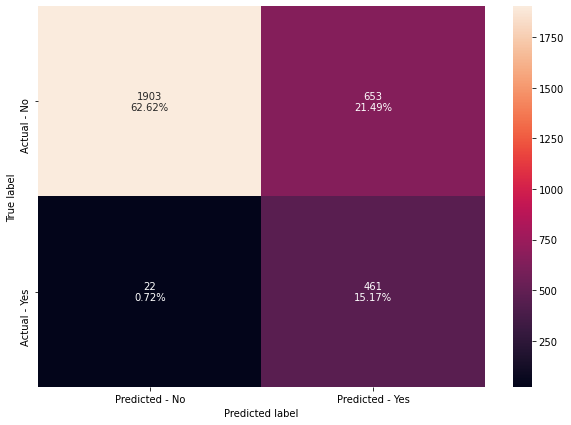

In [ ]:
xgb_tuned2_score = model_score(xgb_tuned2)
confusion_matrix(xgb_tuned2,y_test)

- Comparing hypertuned XGBoost models, we get a recall of 0.9772
and 0.9544 using GridSerachCV and RandomizedSearchCV.
- However, GridSearchCV took more than one hour using GPU while RandomizedSearchCV took just about 3 minutes even if recall is slightly lesser

# Results

- Overall XGBoost performed better. Although GridSearchCV took a lot of time which is expected. 
- RandomizedSearchCV gave closer result and took less time
- AdaBoost did overfit the data and had a less recall score in test set

# Insights

- Customers with low income (less than 40k) are attriting more compared to other groups
- Maybe we can target higher income customers who are more loyal
- Attrited customers generally spend less compared to existing customers
- Attrited customers also made lesser transactions. Maybe the card was not useful for them. We can come up with some attractive incentives (cashback/miles) to retain customers